In [1]:
# create a model that uses the fenchel-young loss and trains on 200 images 
# the images are permuted in 9 tiles and in every iteration a new permutation is generated.
# we use a deep encoder with fixed parameters, adam optimizer, preprocessing before tiling  

import tensorflow as tf

2022-11-03 09:20:58.293937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from ast import Pass
import platform
import cv2
import numpy as np
import os
from pathlib import Path

number_of_images = 1000

root = os.getcwd() # Don't change this
data_dirname = '/data_test/plantvillage/' # Change as you like 
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) 
if platform.system()=='Darwin':
  root = os.getcwd() # Don't change this
  data_dirname = '/data_test/plantvillage/' # Change as you like 
  p = Path(root + data_dirname)
  p.mkdir(exist_ok=True) 
else:
  #p = Path("C:/Users/mwels/Documents/Uni/11. Semester/Deep learning in visual recognition/Plant_leave_diseases_dataset_without_augmentation")
  #p.mkdir(exist_ok=True)
  pass



classes = [
  'Apple___Apple_scab',
  'Apple___healthy',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  "all"
  ]

if "all" in classes:
  classes = os.listdir(p)

for c in classes:
  print(c,end=" ")
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))


filelist = filelist[:number_of_images]
print(len(filelist))

Apple___Cedar_apple_rust Apple___Apple_scab Apple___Black_rot Apple___healthy 250


In [3]:
len(filelist)

250

In [4]:
tilex = 3
number_of_tiles = tilex**2
number_of_permutations = 1000
target_siz = (224,224,3)
tile_size = target_siz[0]//tilex
sfmax = True

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=target_siz)

In [5]:
from keras.layers import Dense, Concatenate, Input, Flatten, Lambda, GlobalAveragePooling2D
from keras.models import Model
import os


#tiles = Input((number_of_tiles,tile_size,tile_size,3))
tiles = Input(target_siz)

inputs = {}
layers = {}
embedds = {}

shared_conv = conv_base 

# for i in range(number_of_tiles):
#     #inputs[f'tiles{i}'] = Input((tile_size,tile_size,3))
#     #layers[f'tile{i}'] = Lambda(lambda x: x[:,i,:,:,:])(tiles)

#     #layers[f'deep_layers{i}'] = shared_conv(inputs[f'tiles{i}'])
#     layers[f'deep_layers{i}'] = shared_conv(layers[f'tile{i}'])
#     embedds[f'embedd{i}'] = Flatten()(layers[f'deep_layers{i}'])
#concatonation = Concatenate(axis=1)(list(embedds.values()))

concatonation = shared_conv(tiles)
concatonation = GlobalAveragePooling2D()(concatonation)

out = Dense(number_of_tiles*10, activation="relu", kernel_initializer='he_normal')(concatonation)
if sfmax:
    out = Dense(number_of_permutations, activation="softmax", kernel_initializer='he_normal')(out)
else:
    out = Dense(number_of_tiles, kernel_initializer='he_normal')(out)
out = Flatten()(out)

model = Model(inputs=tiles, outputs=out)
#model = Model(inputs=list(inputs.values()), outputs=out)

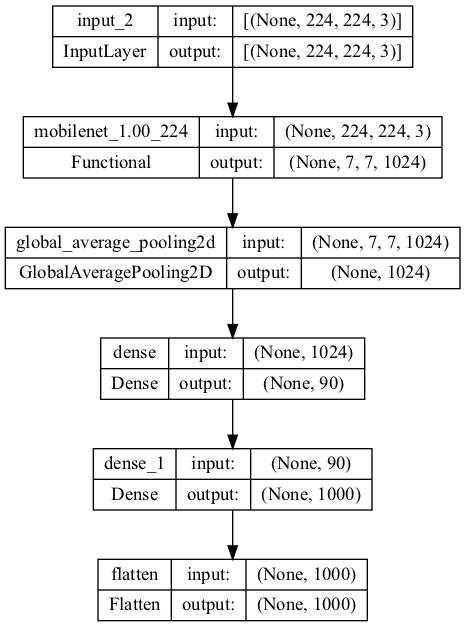

In [6]:
tf.keras.utils.plot_model(model, 
    show_shapes=True)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 90)                92250     
                                                                 
 dense_1 (Dense)             (None, 1000)              91000     
                                                                 
 flatten (Flatten)           (None, 1000)              0     

In [8]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:3]:
    layer.trainable=False
for layer in model.layers[3:]:
    layer.trainable=True

Total number of layers is 6
Number of pretrained base layers is 86


In [9]:
sys.path.append('src')

In [10]:
from keras import optimizers
from sklearn.model_selection import train_test_split
from src.PermOneHotDataGen import *
from src.model_tools import *
from src.permutation_tools import *

x_train, x_test = train_test_split(filelist)

train_generator = PermOneHotDataGen(x_train,
                                    batch_size=8,
                                    tilenumberx=tilex, 
                                    shuffle_permutations=True)

validation_generator = PermOneHotDataGen(x_test,
                                        batch_size=8,
                                        tilenumberx=tilex,
                                        shuffle_permutations=True)

train_generator_sm = PermOneHotDataGen(x_train,
                                    batch_size=1,
                                    tilenumberx=tilex, max_perms=number_of_permutations)

validation_generator_sm = PermOneHotDataGen(x_test,
                                        batch_size=1,
                                        tilenumberx=tilex, max_perms=number_of_permutations)

train_stitch_sm = PermOneHotDataGen(x_train,
                                    batch_size=16,
                                    tilenumberx=tilex,
                                    shuffle_permutations=True,
                                    max_perms=number_of_permutations,
                                    target_size=target_siz, 
                                    stitched=True,
                                    one_hot_encoding=True)

validation_stitch_sm = PermOneHotDataGen(x_test,
                                        batch_size=len(x_test),
                                        tilenumberx=tilex, 
                                        max_perms=number_of_permutations, 
                                        target_size=target_siz, 
                                        stitched=True,
                                        one_hot_encoding=True)


optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)

if sfmax:
    model.compile(optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'])
else:
    model.compile(
        optimizer=optimizer,
        loss=RankingLoss(),
        metrics=[ProjectedRanksAccuracy(), PartialRanksAccuracy()])


In [11]:
print(train_generator.next()[1].shape)
print(train_generator_sm.next()[1].shape)
print(validation_generator.next()[1].shape)
print(validation_generator_sm.next()[1].shape)
print(train_generator.next()[0].shape)
print(train_generator_sm.next()[0].shape)
print(validation_generator.next()[0].shape)
print(validation_generator_sm.next()[0].shape)

(8, 9)
(1, 9)
(8, 9)
(1, 9)
(8, 9, 85, 85, 3)
(1, 9, 85, 85, 3)
(8, 9, 85, 85, 3)
(1, 9, 85, 85, 3)


In [12]:
ProjectedRanksAccuracy().update_state(validation_generator.next()[1], validation_generator.next()[1])

In [13]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [14]:
nb_epochs = 10

model.fit(train_stitch_sm,
          epochs = nb_epochs,
          validation_data=validation_stitch_sm,
          verbose=1)

Epoch 1/10
12/12 [==============================] - 15s 948ms/step - loss: 7.2761 - accuracy: 0.0000e+00 - val_loss: 7.1367 - val_accuracy: 0.0000e+00
Epoch 2/10
12/12 [==============================] - 11s 930ms/step - loss: 6.5115 - accuracy: 0.0160 - val_loss: 7.5028 - val_accuracy: 0.0000e+00
Epoch 3/10
12/12 [==============================] - 10s 836ms/step - loss: 5.9969 - accuracy: 0.0267 - val_loss: 7.9341 - val_accuracy: 0.0000e+00
Epoch 4/10
12/12 [==============================] - 9s 794ms/step - loss: 5.2452 - accuracy: 0.0856 - val_loss: 8.3585 - val_accuracy: 0.0000e+00
Epoch 5/10
12/12 [==============================] - 9s 753ms/step - loss: 4.5326 - accuracy: 0.1016 - val_loss: 8.8615 - val_accuracy: 0.0000e+00
Epoch 6/10
12/12 [==============================] - 9s 803ms/step - loss: 3.7752 - accuracy: 0.2781 - val_loss: 9.3231 - val_accuracy: 0.0000e+00
Epoch 7/10
12/12 [==============================] - 9s 768ms/step - loss: 3.1393 - accuracy: 0.4171 - val_loss: 9.837

In [15]:
#model.save("models/2022_10_27__01")